In [1]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
import operator 
import numpy as np
#plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

In [3]:
cols = confirmed_df.keys()
# from 1/22/2020 to 2/23/2021
confirmed = confirmed_df.loc[:, cols[11]:cols[409]]
dates = confirmed.keys()
world_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    world_cases.append(confirmed_sum)

In [4]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)

In [5]:
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '2/14/21', '2/15/21', '2/16/21', '2/17/21', '2/18/21', '2/19/21',
       '2/20/21', '2/21/21', '2/22/21', '2/23/21'],
      dtype='object', length=399)

In [6]:
import datetime
date_1 = datetime.datetime.strptime("2/23/21", "%m/%d/%y")
end_date = date_1 + datetime.timedelta(days=10)
print(end_date)

2021-03-05 00:00:00


In [7]:
base = datetime.datetime.strptime("2/23/21", "%m/%d/%y")
date_list = [base + datetime.timedelta(days=x) for x in range(1,11)]
print(date_list)

[datetime.datetime(2021, 2, 24, 0, 0), datetime.datetime(2021, 2, 25, 0, 0), datetime.datetime(2021, 2, 26, 0, 0), datetime.datetime(2021, 2, 27, 0, 0), datetime.datetime(2021, 2, 28, 0, 0), datetime.datetime(2021, 3, 1, 0, 0), datetime.datetime(2021, 3, 2, 0, 0), datetime.datetime(2021, 3, 3, 0, 0), datetime.datetime(2021, 3, 4, 0, 0), datetime.datetime(2021, 3, 5, 0, 0)]


In [8]:
confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21
0,0,0,0,0,0,0,0,0,0,0,...,6023,6024,6038,6050,6071,6079,6092,6117,6121,6143
1,0,0,0,0,0,0,0,0,0,0,...,19105,19136,19176,19267,19324,19361,19392,19433,19461,19554
2,0,0,0,0,0,0,0,0,0,0,...,2042,2044,2055,2053,2057,2061,2067,2070,2074,2084
3,0,0,0,0,0,0,0,0,0,0,...,2395,2397,2400,2399,2405,2411,2414,2416,2417,2432
4,0,0,0,0,0,0,0,0,0,0,...,5961,5973,5987,5997,6008,6021,6040,6042,6043,6058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,0,0,0,0,0,0,0,0,0,0,...,3278,3278,3297,3298,3307,3318,3318,3326,3331,3333
3338,0,0,0,0,0,0,0,0,0,0,...,1994,1994,2007,2016,2021,2024,2024,2027,2030,2036
3339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3340,0,0,0,0,0,0,0,0,0,0,...,873,873,874,874,875,877,877,877,879,880


# with date

In [9]:
# Future Forecasting

days_in_future = 10
# Start from 1/22/2020
base = datetime.datetime.strptime("1/22/20", "%m/%d/%y")
future_forcast = np.array([base + datetime.timedelta(days=x) for x in range(0,len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-days_in_future]
time_list = [i[0].strftime('%m/%d/%Y') for i in adjusted_dates]
future_forcast = np.array([i for i in range(len(dates))]).reshape(-1, 1)


# Convert datatime

start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [10]:
days_in_future = confirmed.shape[1] - int(confirmed.shape[1]*0.8)
days_in_future

80

In [11]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.2, shuffle=False)

In [12]:
print(X_train_confirmed.shape)
print(X_test_confirmed.shape)

(319, 1)
(80, 1)


In [13]:
# Prediction plot function
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    start = datetime.datetime.strptime("1/22/20", "%m/%d/%y")
    then = start + datetime.timedelta(days=len(x))
    days = mdates.drange(start,then,datetime.timedelta(days=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.plot(days, y)
    plt.gcf().autofmt_xdate()
    then_2 = start + datetime.timedelta(days=len(future_forcast))
    future_forcast_days = mdates.drange(start,then_2,datetime.timedelta(days=1))
    plt.plot(future_forcast_days, pred, linestyle='dashed', color=color)
    plt.title('US Coronavirus Cases Over Time', size=15)
    plt.xlabel('Days Since 1/22/2020', size=15)
    plt.ylabel('# of Cases', size=15)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 15})
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.savefig(algo_name+".tiff")
    plt.savefig(algo_name+".png")
    plt.show()

# SVM

Model fitting time:  0.1409 seconds.
Prediction time:  0.0014 seconds.
MAE: 2718970.7595524974
MSE: 8239019349726.525


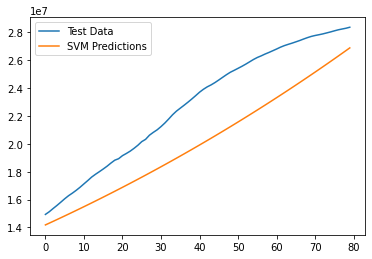

In [14]:
# SVM 

svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
tic1 = time.perf_counter()
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
toc2 = time.perf_counter()
print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")
svm_pred = svm_confirmed.predict(future_forcast)


# check against testing data
tic1 = time.perf_counter()
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
toc2 = time.perf_counter()
print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [15]:
# Calculate the RMSE and accuracy 
# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(y_test_confirmed, svm_test_pred)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(y_test_confirmed, svm_test_pred)
print("R2: ", acc_r2)

print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(y_test_confirmed.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(svm_test_pred.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(x_scaled, pred_scaled)
print("R2: ", acc_r2)

Before normalized:
RMSE:  6223103.5143268425
R2:  0.5311980634350375
After normalized
RMSE:  0.1368931268129937
R2:  0.8080933115197231


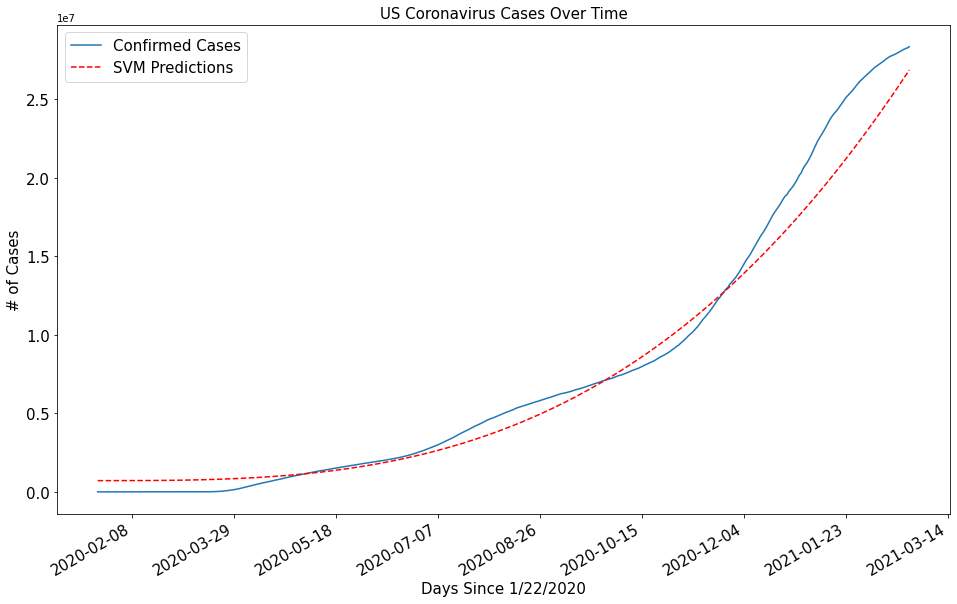

In [16]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'red')

# Bayesian ridge regression

In [17]:
# transform our data for bayesian ridge regression
bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [18]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
tic1 = time.perf_counter()
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)
toc2 = time.perf_counter()
print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Model fitting time:  5.6240 seconds.


In [19]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': False,
 'lambda_2': 1e-06,
 'lambda_1': 0.001,
 'alpha_2': 0.0001,
 'alpha_1': 1e-06}

In [20]:
bayesian_confirmed = bayesian_search.best_estimator_
tic1 = time.perf_counter()
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
toc2 = time.perf_counter()
print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")

bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

Prediction time:  0.0005 seconds.
MAE: 2759350.395936046
MSE: 18256718687876.938


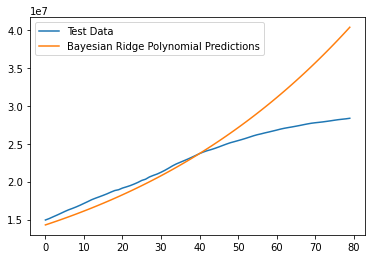

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [22]:
# Calculate the RMSE and accuracy 
# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(y_test_confirmed, test_bayesian_pred)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(y_test_confirmed, test_bayesian_pred)
print("R2: ", acc_r2)

print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(y_test_confirmed.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(test_bayesian_pred.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(x_scaled, pred_scaled)
print("R2: ", acc_r2)

Before normalized:
RMSE:  8885739.188485373
R2:  -0.03881113915365897
After normalized
RMSE:  0.20256438802856655
R2:  0.5798029326228247


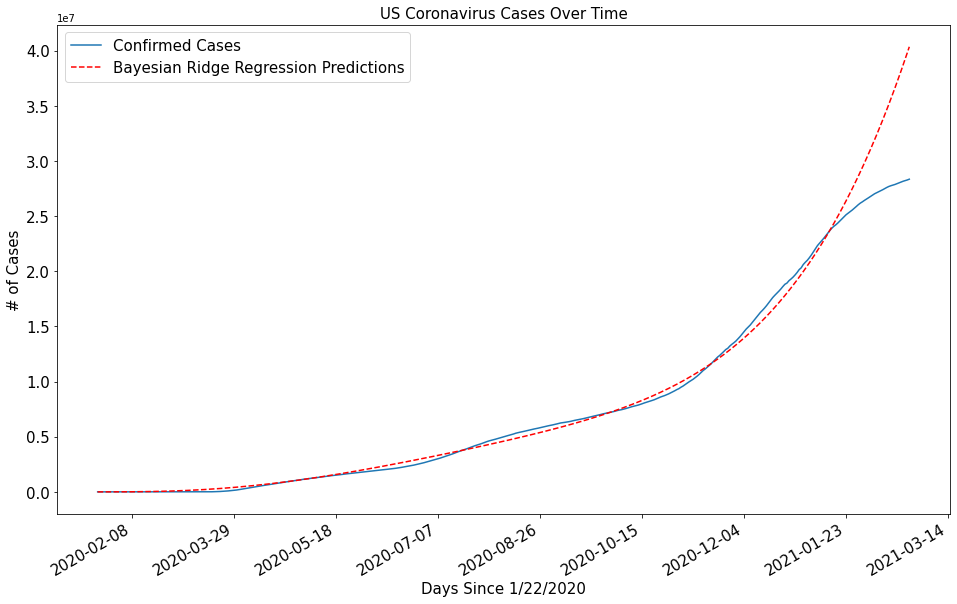

In [23]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'red')

# XGBoost

Model fitting time:  4.0415 seconds.
Prediction time:  0.4187 seconds.
MAE: 15543786.15
MSE: 259006877652765.5


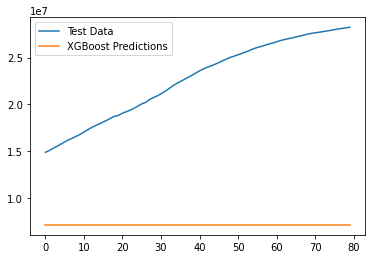

In [177]:
from xgboost import XGBClassifier

xgb_confirmed = XGBClassifier()
tic1 = time.perf_counter()
xgb_confirmed.fit(X_train_confirmed, y_train_confirmed)
toc2 = time.perf_counter()
print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")
xgb_pred = xgb_confirmed.predict(future_forcast)


# check against testing data
tic1 = time.perf_counter()
xgb_test_pred = xgb_confirmed.predict(X_test_confirmed)
toc2 = time.perf_counter()
print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")
plt.plot(y_test_confirmed)
plt.plot(xgb_test_pred)
plt.legend(['Test Data', 'XGBoost Predictions'])
print('MAE:', mean_absolute_error(xgb_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(xgb_test_pred, y_test_confirmed))

In [178]:
# Calculate the RMSE and accuracy 
# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(y_test_confirmed, xgb_test_pred)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(y_test_confirmed, xgb_test_pred)
print("R2: ", acc_r2)

print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(y_test_confirmed.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(xgb_test_pred.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(x_scaled, pred_scaled)
print("R2: ", acc_r2)

Before normalized:
RMSE:  16093690.61628704
R2:  -13.887514936841516
After normalized
RMSE:  0.6629365769810904
R2:  -3.4946837813731175


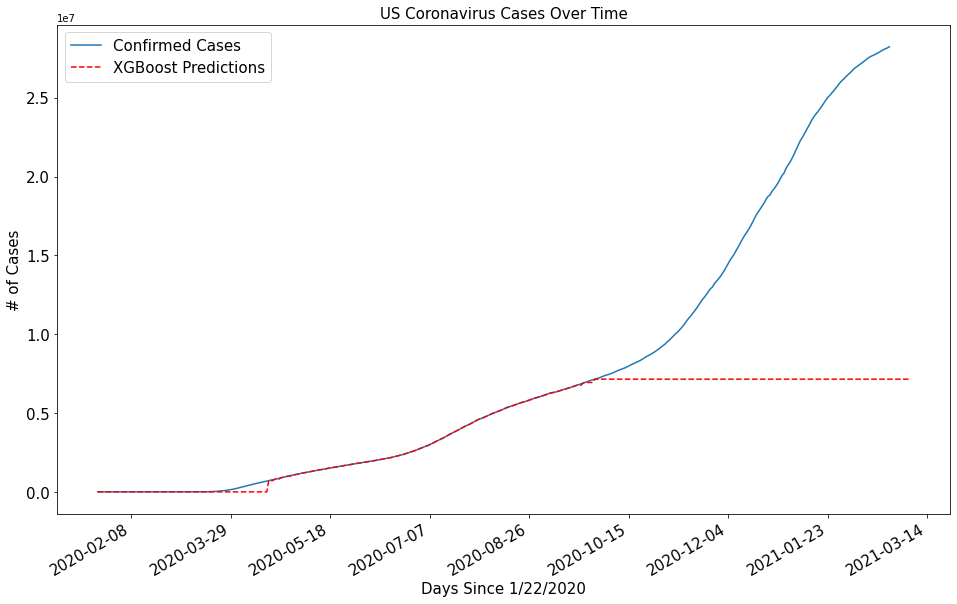

In [179]:
plot_predictions(adjusted_dates, world_cases, xgb_pred, 'XGBoost Predictions', 'red')

# Decision Tree

Model fitting time:  0.0321 seconds.
Prediction time:  0.0008 seconds.
MAE: 7978214.15
MSE: 81049490799093.92


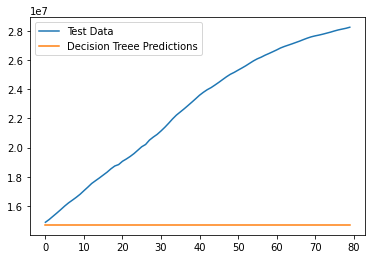

In [180]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt_confirmed = DecisionTreeClassifier(random_state=0)
tic1 = time.perf_counter()
dt_confirmed.fit(X_train_confirmed, y_train_confirmed)
toc2 = time.perf_counter()
print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")
dt_pred = dt_confirmed.predict(future_forcast)

# check against testing data
tic1 = time.perf_counter()
dt_test_pred = dt_confirmed.predict(X_test_confirmed)
toc2 = time.perf_counter()
print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")
plt.plot(y_test_confirmed)
plt.plot(dt_test_pred)
plt.legend(['Test Data', 'Decision Treee Predictions'])
print('MAE:', mean_absolute_error(dt_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(dt_test_pred, y_test_confirmed))

In [181]:
# Calculate the RMSE and accuracy 
# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(y_test_confirmed, dt_test_pred)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(y_test_confirmed, dt_test_pred)
print("R2: ", acc_r2)

print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(y_test_confirmed.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(dt_test_pred.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(x_scaled, pred_scaled)
print("R2: ", acc_r2)

Before normalized:
RMSE:  9002749.068984091
R2:  -3.658662024073963
After normalized
RMSE:  0.6629365769810904
R2:  -3.4946837813731175


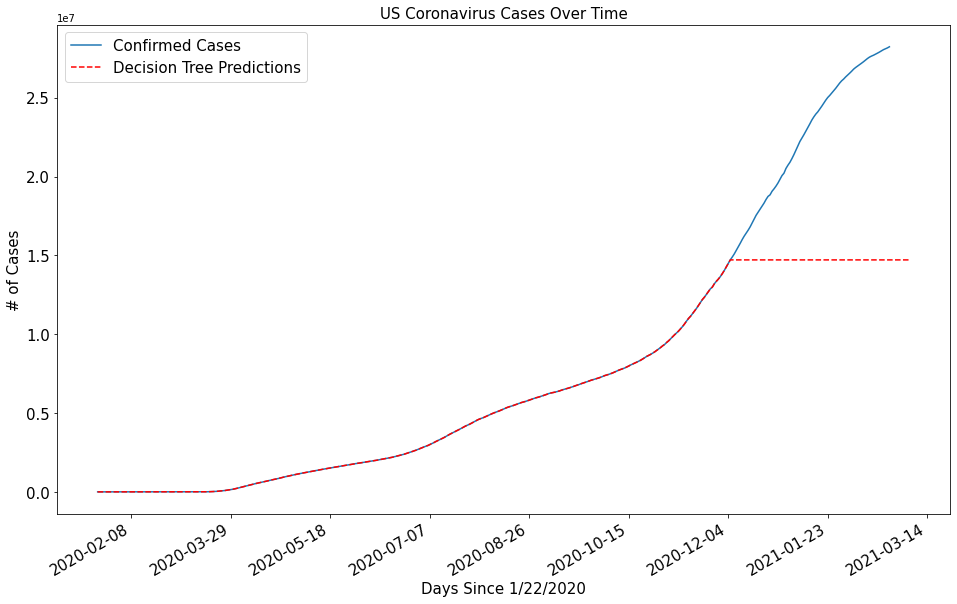

In [182]:
plot_predictions(adjusted_dates, world_cases, dt_pred, 'Decision Tree Predictions', 'red')